# **In this Notebook you will learn:**
1. **Textcleaning and visualization**
2. **Text sentiment analysis using NLTk's inbuilt Naive Byes**
3. **Text Sentiment analysis using TextBLob unsupervised method**
4. **Text sentiment analysis using Logistic regression TF-IDF Approach**


Run all the code and do change the code to learn and explore more things 🙂

# **Importing the Necessary Libraries**

In [ ]:
!pip install -U textblob
!python -m textblob.download_corpora

In [ ]:
import pandas as pd       #import NLTK , Regex , TextBlob and all necesary libraries
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from sklearn.model_selection import train_test_split
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
from wordcloud import WordCloud,STOPWORDS
nltk.download("stopwords")
stopwords_set = set(stopwords.words("english"))
%matplotlib inline
pd.options.mode.chained_assignment = None

# **Loading the Stock tweet Data**

In [ ]:
# Download the Data from kaggle https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset //Upload on colab
df = pd.read_csv("/content/stock_data.csv")

In [ ]:
df.head(5)

# **Text Cleaning using RegEx and NLTK**

---



STOP WORDS REMOVAL "WE ARE REMOVING NEGATION SO THAT THE RESULTS ARE BETTER WHILE PREDICTION"

In [ ]:
stopwords_list = set(stopwords.words("english"))   #stopwords downloading from NLTK in english
print(f'List of stopwords:\n{stopwords_list}\n')

# We remove negation words in list of stopwords
no_stopwords = ["not","don't",'aren','don','ain',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
               'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
               "won't", 'wouldn', "wouldn't"]
for no_stopword in no_stopwords:
    stopwords_list.remove(no_stopword)

#print(stopwords_list)
print(f'Final list of stopwords:\n{stopwords_list}')


Using RegEX for Negation transformation

In [ ]:
re_negation = re.compile("n't ")
# function that receive a sequence of woords and return the same sequence transforming
# abbreviated negations to the standard form.
def negation_abbreviated_to_standard(sent):
    sent = re_negation.sub(" not ", sent)
    return sent

word_example = "I aren't "
print(f'The sentence "{word_example}" is transformed to "{negation_abbreviated_to_standard(word_example)}"')

Using Lemmatization for getting the stem word from the original word

In [ ]:
# Import Lemmatizer from NLTK
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# function that receive a list of words and do lemmatization:
def lemma_stem_text(words_list):
    # Lemmatizer
    text = [lemmatizer.lemmatize(token.lower()) for token in words_list]# eighties->eight or messages->message or drugs->drug
    text = [lemmatizer.lemmatize(token.lower(), "v") for token in text]# going-> go or started->start or watching->watch
    return text

word_example = "Killing"
print(f'The word "{word_example}" is transformed to "{lemma_stem_text([word_example])[0]}"')

Combining all the above functions into single for cleaning the text

In [ ]:
def clean(review_text):

    # 1. Transform abbreviated negations to the standard form.
    review_text = negation_abbreviated_to_standard(review_text)

    # 2. Remove non-letters and non-numbers
    letters_numbers_only = re.sub("[^a-zA-Z_0-9]", " ", review_text)   #keeping only numbers and letters

    # 3. Convert to lower case and split into individual words (tokenization)
    words = np.char.lower(letters_numbers_only.split())

    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stopwords_list]

    # 5. Apply lemmatization function
    lemma_words = lemma_stem_text(meaningful_words)

    # 6. Join the words back into one string separated by space, and return the result.
    return( " ".join(lemma_words))

In [ ]:
#Cleaning each stock tweet using the clean function
for i , j in enumerate(df['Text'].tolist()):
  df['Text'][i] = clean(j)

In [ ]:
df.tail(5)  #cleaned Data Frame visualization

,Text,Sentiment
5786,industry body cii say discoms likely suffer ne...,-1
5787,gold price slip r 46 000 investor book profit ...,-1
5788,worker bajaj auto agree 10 wage cut period apr...,1
5789,sharemarket live sensex day high 600 point nif...,1
5790,sensex nifty climb day high still 2 key factor...,1


# **Train Test spliting and worldcloud Visualization of the data**

Train Test Spliting 🙂

In [ ]:
# Splitting the dataset into train and test set using Scikit Learn
train, test = train_test_split(df,test_size = 0.1)
# Removing neutral sentiments
train = train[train.Sentiment != 0]

Creating the tupple list of the training dataset for feature extraction for training

In [ ]:
tweets = []   #creating a list of tuples of cleaned training text with their sentiment for feature extraction
for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.Text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.Sentiment))

Creating Function for word feature extraction from the given training data

In [ ]:
#these all functions given below are for creating the overall TF-IDF matrix for training data
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):                              #returns most occuring unique words
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):           #this function is creating the feature matrix for the training data
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

WorldCloud Generation ☁

In [ ]:
def wordcloud_draw(data, color = 'black'):            #this function generates the worldcloud from the given data using Scikit Learns Function
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [ ]:
pos = [j for i , j in enumerate(df['Text']) if df['Sentiment'][i]==1 ]  #creating positive and negative text list for worldcloud visualization
neg = [j for i , j in enumerate(df['Text']) if df['Sentiment'][i]== -1]

Visualization of positive and negative words in the dataset

Positive words in the Dataset


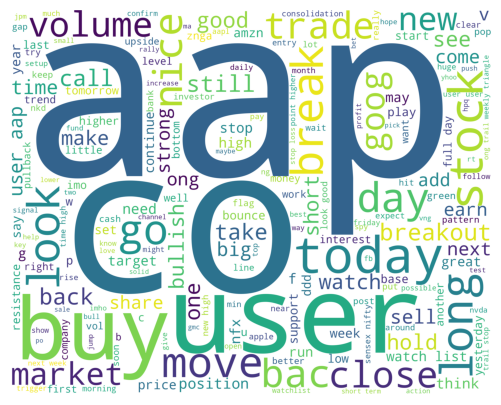

In [ ]:
print("Positive words in the Dataset")
wordcloud_draw(pos,'white')

Negative words in the Dataset


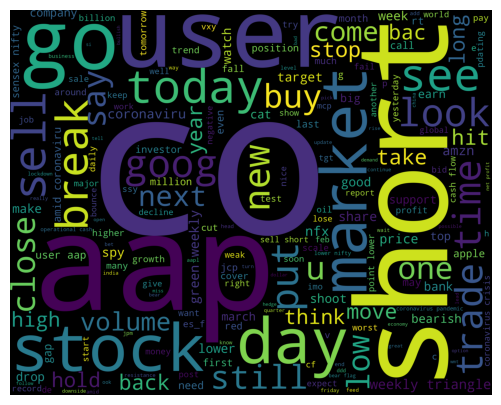

In [ ]:
print("Negative words in the Dataset")
wordcloud_draw(neg)

Visualization of the word features of the training dataset

Feature Words of the Training Dataset


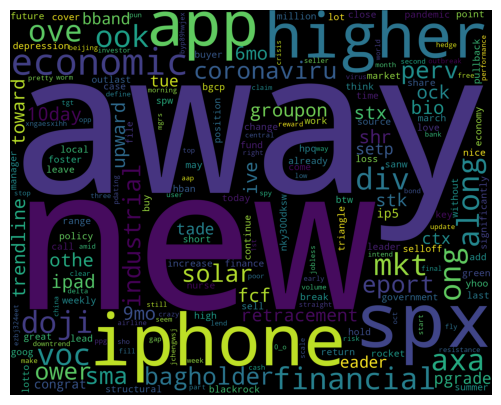

In [ ]:
print("Feature Words of the Training Dataset")
wordcloud_draw(w_features)

# **Training using NLTK's inbuilt NAIVE-BYES Estimator**

In [ ]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)    #Naive byes classifier

Storing the prediction from the predictor in y_pred for accuracy calculation

In [ ]:
y_test = test['Sentiment']
y_pred = []
for obj in test['Text'].tolist():
    res =  classifier.classify(extract_features(obj.split()))   #classifier storing the result from extracted features of the testing dataset
    if(res == 0):                    #handling neutral sentiment
      y_pred.append(1)
    else :
      y_pred.append(res)

Calculating and printing the Confusion Matrix

In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[126,  90],
       [ 39, 325]])

Text(0.5, 445.55555555555554, 'Predicted label')

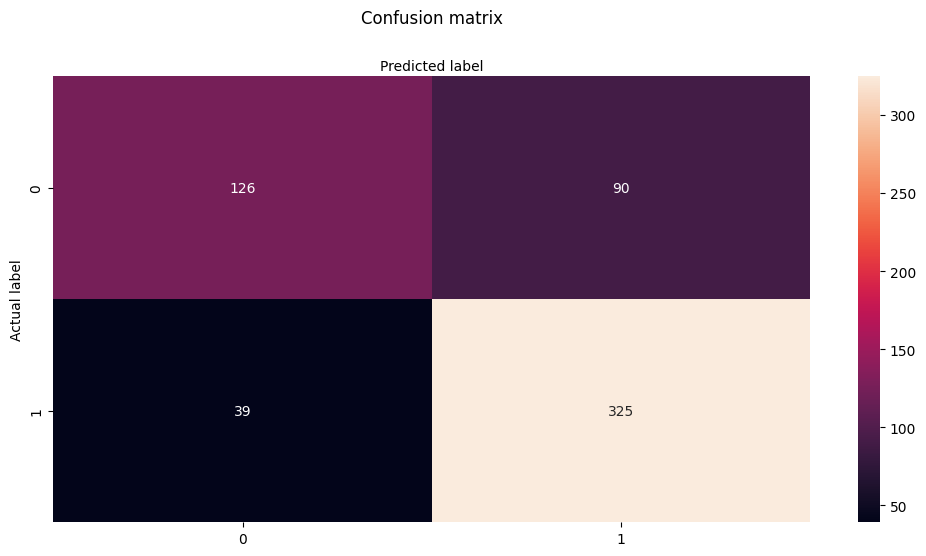

In [ ]:
import seaborn as sns
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Calculating essential Metrics such as Precision / Recall and Accuracy

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7775862068965518
Precision: 0.7831325301204819
Recall: 0.8928571428571429


# **Sentiment extraction using TextBlob library**

**The Sentiment Analysis of TextBlob returns two properties:**

1.Polarity

2.Subjectivity



*   Polarity It simply means emotions expressed in a sentence.

*   Emotions are closely related to sentiments. The strength of a sentiment or
    opinion is typically linked to the intensity of certain emotions, e.g., joy and anger.

*   The range of the Polarity lies in [-1 , 1] where 1 is a positive statment
    and -1 is negative statement. Values with 0 is Neutral statment

*   Subjectivity Subjective sentence expresses some personal individual
    feelings, views, or beliefs.

*   The range of Subjectivity is [0 , 1] where 0 is very objective and 1 is  
    very Subjective.




In [ ]:
print(df['Text'][1])   #printing the original text
print(df['Sentiment'][1])
Tweet = TextBlob(df['Text'][1])
Tweet.sentiment[0]       #printing the sentiment

user aap movie 55 return fea gee indicator 15 trade year awesome
1


1.0

In [ ]:
#letus Evaluate this unsupervised method
y_true = df['Sentiment'].tolist()
y_pred_tb = []
for i , j in enumerate(df['Text'].tolist()):
  if int(TextBlob(j).sentiment[0]) >= 0:
    y_pred_tb.append(1)
  else :
    y_pred_tb.append(-1)

Calculating and printing the Confusion Matrix

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_true, y_pred_tb)
cnf_matrix #this method does not works very well due insufficiencnt or very subjective text

array([[  10, 2096],
       [   3, 3682]])

Text(0.5, 445.55555555555554, 'Predicted label')

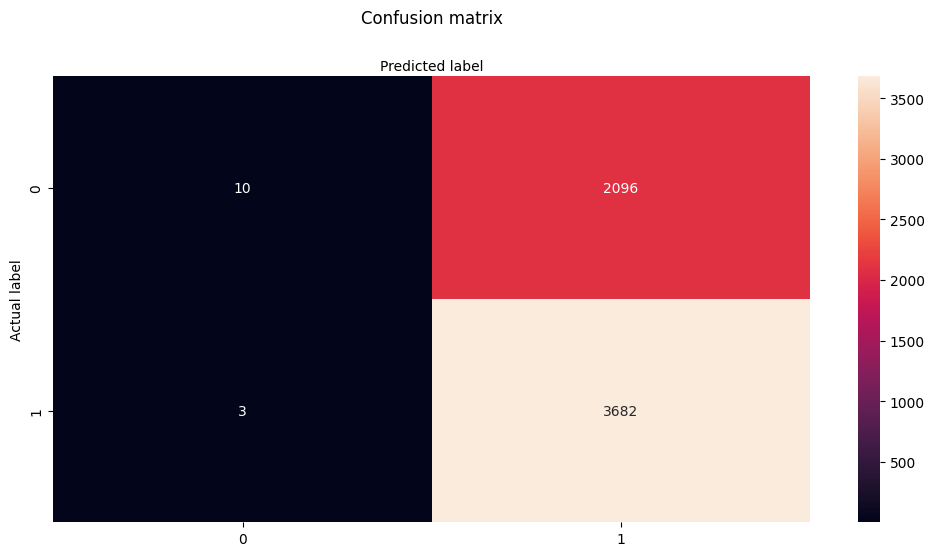

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_true, y_pred_tb))
print("Precision:",metrics.precision_score(y_true, y_pred_tb))
print("Recall:",metrics.recall_score(y_true, y_pred_tb))  #overall accuracy is not very good as it is not good in identifying the negative samples.

Accuracy: 0.6375410119150405
Precision: 0.6372447213568709
Recall: 0.9991858887381275


# **Sentiment Analysis using Logistic Regression using TF-IDF approach**

Creating training and testing features

In [ ]:
x_train = train['Text']                     #creating features and labels for the training and testing for logistic regression making it a binary classification problem
y_train = train['Sentiment']
x_test = test['Text']
y_test = test['Sentiment']

In [ ]:
train.head()  #visualizing the training dataset

,Text,Sentiment
2601,sanw btw not buyer already lot add pullback th...,1
5198,coronavirus pandemic may like great depression...,-1
528,green weekly triangle hban sell short 6 69,-1
2854,hpq buy march 19 lotto call close case,1
1747,goog 10 point away new hold time high market l...,1


Vectorizing the whole training dataset using words as features of the text using TF-IDF Vectorizer from sklearn

In [ ]:
# Import tf-idf encoding from sklearn library
from sklearn.feature_extraction.text import TfidfVectorizer

# Define some hyperparameters of encoded
vectorizer = TfidfVectorizer(max_features=20000, ngram_range = (1,2))

# Create the training set with the words encoded as features of the text
train_data_features = vectorizer.fit_transform(x_train)

print(train_data_features.shape) #training data in the trainable format

(5211, 20000)


Loading Logistic Regression model from scikit learn for classification and training

In [ ]:
# Import the logistic regression model from sklearn
from sklearn.linear_model import LogisticRegression
# Define the model
model = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
# Train model
model.fit(train_data_features, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

predicting using the Model

In [ ]:
# Create the test set with the words encoded as features of the reviews
test_data_features = vectorizer.transform(x_test)    #vectorizing the test dataset

# Use the logistic regression model to make sentiment label predictions
result = model.predict(test_data_features)   #predicting the test data set

# Copy the results to a pandas dataframe with an "id" column and a "sentiment" column
y_pred_LR = result
y_test = test['Sentiment']

Calculating Confusion matrix and visualizing it

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_LR)
cnf_matrix

array([[139,  77],
       [ 43, 321]])

Text(0.5, 445.55555555555554, 'Predicted label')

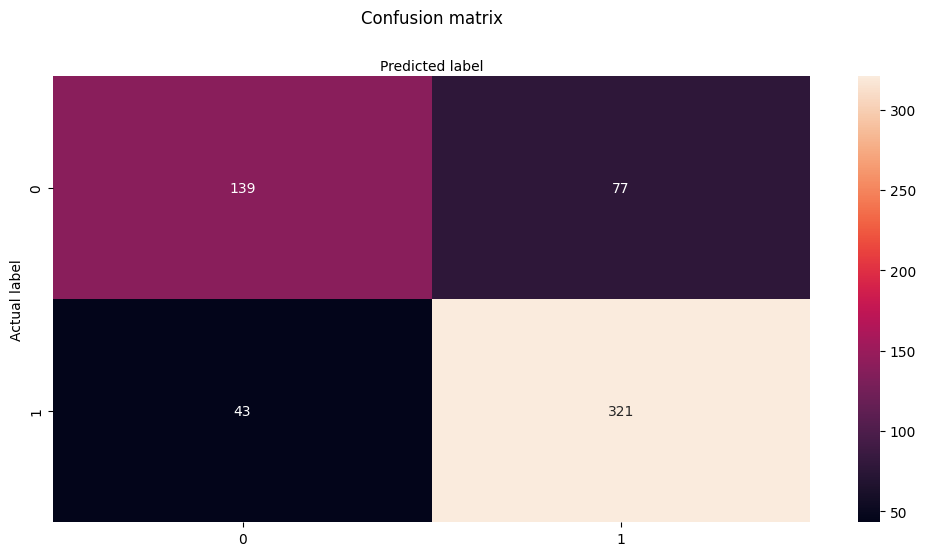

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,  color = 'Red'  ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Overall accuracy and precision recall calculation

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_LR))
print("Precision:",metrics.precision_score(y_test, y_pred_LR))
print("Recall:",metrics.recall_score(y_test, y_pred_LR)) #overall this model gives very good accuracy of 78% which is better than both NB and TextBLob

Accuracy: 0.7931034482758621
Precision: 0.8065326633165829
Recall: 0.8818681318681318


END 🙂